In [30]:
import os
from collections import defaultdict

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams

LOGS_PATH = "../../logs"

sns.set_theme(style="ticks")
sns.set_style('whitegrid')

get_data = lambda path:  pd.read_excel(path,engine="openpyxl", usecols="B:H")

In [2]:
def get_exp_results_by_noise(pts:int=200):
    
    exp_data = defaultdict(dict)

    for dataset in os.listdir(LOGS_PATH):

        dataset_path = os.path.join(LOGS_PATH, dataset)
        model_results = defaultdict(dict)

        for model in sorted(os.listdir(dataset_path), key=lambda x: x.lower()):

            model_path = os.path.join(dataset_path, model)

            filter_fn = lambda x: (
                x[-4:] == "xlsx" and \
                int(x.split("_")[2].split("-")[1]) == pts
            )
            for file in filter(filter_fn, os.listdir(model_path)):
                header = file.split("_")
                model = header[0]
                noise = header[1].split("-")[1]
                
                if model_results[model].get(noise) is None:
                    tmp = get_data(os.path.join(model_path, file))
                    tmp["trial"] = [0]*len(tmp)
                    model_results[model][noise] = [tmp]
                    continue
                
                tmp = get_data(os.path.join(model_path, file))
                tmp["trial"] = [len(model_results[model][noise])]*len(tmp)
                
                model_results[model][noise].append(tmp)
                
        exp_data[dataset] = dict(model_results)
            
    return exp_data
            

exp_data = get_exp_results_by_noise()

In [3]:
dataset_df = {}

for dataset in os.listdir(LOGS_PATH):

    acc, tim = [], []
    
    df_dict = {
        "model":[],
        "accuracy":[],
        "noise":[],
        "duration":[],
        "trial":[],
    }    
    
    models = sorted(exp_data[dataset].keys())
    for model in models:
        
        noises = sorted(exp_data[dataset][model].keys(), key=lambda x: float(x))
        for noise in noises:
            
            for df_col in exp_data[dataset][model][noise]:
                
                df_col["noise"] = [noise]*len(df_col)
                
                for row in df_col.iterrows():
                    acc = row[1]['accuracy']
                    dur = row[1]['time']
                    trial = row[1]['trial']

                    df_dict["model"].append(model)
                    df_dict["accuracy"].append(acc)
                    df_dict["noise"].append(noise)
                    df_dict["duration"].append(dur)
                    df_dict["trial"].append(trial)

    df = pd.DataFrame(data=df_dict)
    dataset_df[dataset] = df

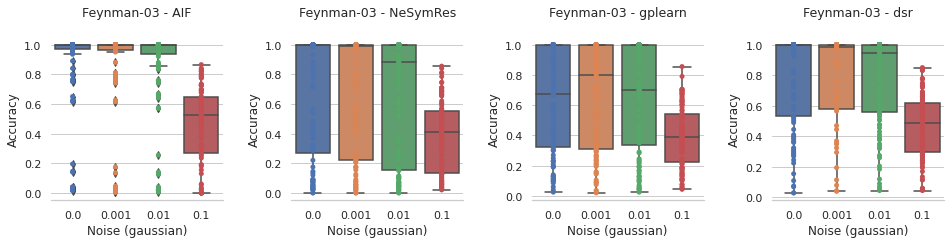

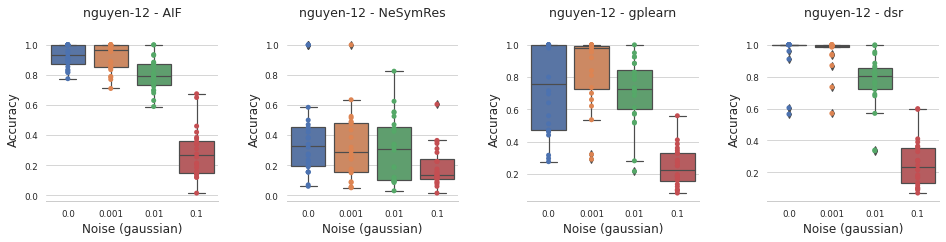

In [31]:
def plot(dataset:str):
    
    f, axs = plt.subplots(1,4,figsize=(16,3))    
    f.subplots_adjust(wspace=0.4)
    
    for i, model in enumerate(["AIF", 'NeSymRes', "gplearn", "dsr"]):
        df = dataset_df[dataset][dataset_df[dataset]['model'] == model]
        df = df[["noise", "accuracy"]]
        

        sns.color_palette("Paired")
        ax = sns.boxplot(x="noise", y="accuracy", data=df,  ax=axs[i])
        sns.stripplot(x="noise", y="accuracy", data=df, jitter=0,  ax=axs[i])

        ax.set_ylabel("Accuracy", fontsize=12)
        ax.set_xlabel("Noise (gaussian)", fontsize=12)
        ax.set_title(f"{dataset} - {model}\n", fontsize=12.5)
    
    sns.set_context("paper")
    sns.despine(left=True)
    
plot("Feynman-03")    
plot("nguyen-12")    

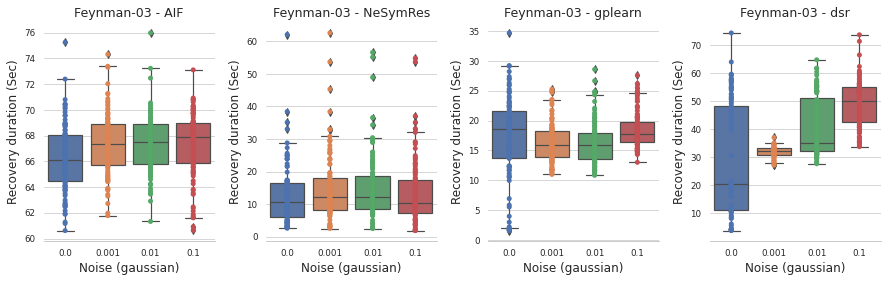

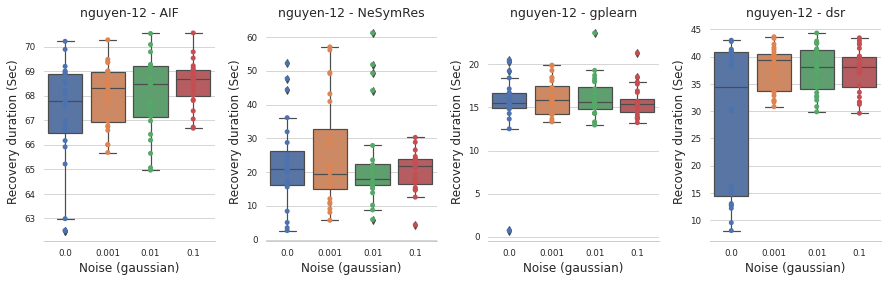

In [32]:
def plot(dataset:str):
    
    f, axs = plt.subplots(1,4,figsize=(15,4))    
    f.subplots_adjust(wspace=0.3)
    
    for i, model in enumerate(["AIF", 'NeSymRes', "gplearn", "dsr"]):
        df = dataset_df[dataset][dataset_df[dataset]['model'] == model]
        df = df[["noise", "duration"]]
        

        sns.color_palette("Paired")
        ax = sns.boxplot(x="noise", y="duration", data=df,  ax=axs[i])
        sns.stripplot(x="noise", y="duration", data=df, jitter=0,  ax=axs[i])

        ax.set_ylabel("Recovery duration (Sec)", fontsize=12)
        ax.set_xlabel("Noise (gaussian)", fontsize=12)
        ax.set_title(f"{dataset} - {model}", fontsize=12.5)
    
    sns.set_context("paper")
    sns.despine(left=True)
    
plot("Feynman-03")    
plot("nguyen-12")    